## Lunar lander TD-0 with the Kalman filter
### Using SARSA

In [1]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

/var/folders/vf/3b13gs616172kztlr53t6_s00000gn/T/ipykernel_45534/2292708056.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
np.set_printoptions(linewidth=200)
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")

In [3]:
env = gym.make("LunarLander-v2")

objc[45534]: Class SDLApplication is implemented in both /Users/gerardoduran/mambaforge/envs/py310/lib/libSDL2-2.0.0.dylib (0x148989288) and /Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1491dc6e0). One of the two will be used. Which one is undefined.
objc[45534]: Class SDLAppDelegate is implemented in both /Users/gerardoduran/mambaforge/envs/py310/lib/libSDL2-2.0.0.dylib (0x1489892d8) and /Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1491dc730). One of the two will be used. Which one is undefined.
objc[45534]: Class SDLTranslatorResponder is implemented in both /Users/gerardoduran/mambaforge/envs/py310/lib/libSDL2-2.0.0.dylib (0x148989350) and /Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1491dc7a8). One of the two will be used. Which one is undefined.
objc[45534]: Class SDLMessageBoxPresenter is im

## Single run

## The action-value function

$$
    q(s, a, {\bf w}) = {\bf w}_a^\intercal\phi(s)
$$

In [4]:
actions = np.arange(4)
n_actions = 4

In [5]:
def phi(s):
    sprime = np.concatenate([
        np.ones(1), s, np.sin(s), np.cos(s),
    ])
    return sprime

def action_value(W, s, a):
    w = W[a]
    return w @ phi(s)

def grad_action_value(W, s, a):
    return phi(s)


def eval_action_value(W, s, actions):
    q_a = np.array([action_value(W, s, ai) for ai in actions])
    return q_a


def choose_max_action(action_value_est):
    vmax = action_value_est.max()
    if np.sum(vmax == action_value_est) == 1:
        return np.argmax(action_value_est)
    else: # break ties
        actions = np.arange(len(action_value_est))
        av_sub = actions[action_value_est == vmax]
        return np.random.choice(av_sub)


def eps_greedy_choice(W, s, eps):
    u = np.random.uniform()
    if u < eps:
        a = np.random.choice(4)
    else:
        action_value_estimates = eval_action_value(W, s, actions)
        a = choose_max_action(action_value_estimates)
    return a


def update_qweights(W, s, a, r, s_next, a_next, gamma, alpha):
    """
    Update weights using SARSA algorithm
    """
    W = np.copy(W)
    td_err = r + gamma * action_value(W, s_next, a_next) - action_value(W, s, a)
    w = W[a] + alpha * td_err * grad_action_value(W, s, a)
    W[a] = w
    return W


def update_qweights_kf(M, Sigma, s, a, r, s_next, a_next, gamma, Rt, qt):
    """
    A first attempt
    """
    M = np.copy(M)
    Sigma = np.copy(Sigma)
    
    m = M[a]
    Sigma_prev = Sigma[a] + np.eye(len(m)) * qt
    gphi = grad_action_value(M, s, a)

    S = np.einsum("i,ik,k->", gphi, Sigma_prev, gphi) + Rt
    K = np.linalg.solve(S, (Sigma_prev @ gphi)[None, :]).T
    td_err = r + gamma * action_value(M, s_next, a_next) - action_value(M, s, a)

    m = m + (K * td_err).ravel()
    Sigma_next = Sigma_prev - K @ S @ K.T

    M[a] = m
    Sigma[a] = Sigma_next
    
    return M, Sigma

## Dynamic filtering
Setting $Q_t = 10^{-4}$

In [6]:
n_steps = 200_000
eps = 5e-4
gamma = 0.9999
Rt = np.eye(1) * 1.0

all_rewards = np.zeros(n_steps)
env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=314)
final_rewards = []

checkpoint_episodes = [1, 250, 500, 750, 1000, 1250, 1500]
checkpoint_weights = []

dim_phi = len(phi(observation))
np.random.seed(314)
M = np.random.randn(n_actions, dim_phi)
M = M.astype("float32")
M = np.zeros((n_actions, dim_phi))
Sigma = np.einsum("a,ij->aij", np.ones(n_actions), np.eye(dim_phi)) * 10.0

n_episodes = 0
action = eps_greedy_choice(M, observation, eps)
episode_reward = 0.0

for t in (pbar := tqdm(range(n_steps))):
    observation_next, reward, terminated, truncated, info = env.step(action)
    
    action_next = eps_greedy_choice(M, observation_next, eps)

    reset = terminated or truncated
    gamma_step = 0.0 if reset else gamma

    qt = 1e-4
    
    M, Sigma = update_qweights_kf(
        M, Sigma, observation, action, reward, observation_next, action_next, gamma_step, Rt, qt
    )
    
    if reset:
        final_rewards.append(episode_reward)
        observation, info = env.reset()
        action = eps_greedy_choice(M, observation, eps)
        episode_reward = 0.0

        if n_episodes in checkpoint_episodes:
            checkpoint_weights.append(M)
        
        n_episodes += 1
    else:
        episode_reward += reward
        observation = observation_next
        action = action_next

    if t % 10_000 == 0:
        pbar.set_description(f"{reward:0.2f}")
    all_rewards[t] = reward

# attach last 
checkpoint_weights.append(M)
checkpoint_episodes.append(n_episodes)

checkpoint_weights = np.stack(checkpoint_weights)
final_rewards = pd.Series(final_rewards)
print(f"\n{all_rewards.sum()}")
env.close()

  0%|                                                                                                                                                         | 0/200000 [00:00<?, ?it/s]/Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
1.29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:33<00:00, 5909.17it/s]


-136058.54273510285


In [7]:
final_rewards.std()

87.50837002335051

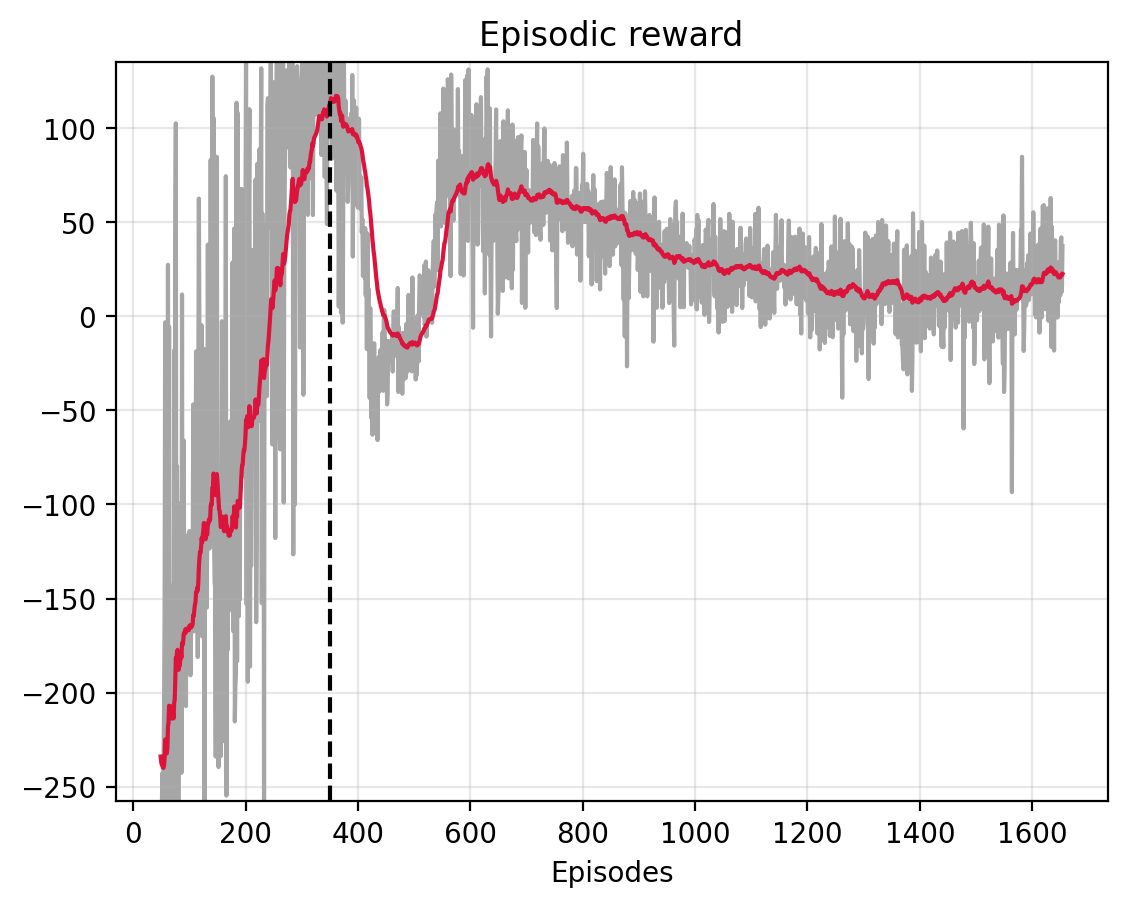

In [8]:
final_rewards.ewm(span=50, min_periods=50).mean().plot(c="crimson")
ymin, ymax = plt.ylim()
final_rewards.iloc[50:].plot(zorder=0, c="gray", alpha=0.7)
plt.ylim(ymin, ymax)
plt.axvline(x=350, c="black", linestyle="dashed")
plt.title("Episodic reward")
plt.xlabel("Episodes")
plt.grid(alpha=0.3)

## Static filtering
Setting $Q_t = 0.0$

In [9]:
n_steps = 200_000
eps = 5e-4
gamma = 0.9999
Rt = np.eye(1) * 1.0

all_rewards = np.zeros(n_steps)
env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=314)
final_rewards = []

checkpoint_episodes = [1, 250, 500, 750, 1000, 1250, 1500]
checkpoint_weights = []

dim_phi = len(phi(observation))
np.random.seed(314)
M = np.random.randn(n_actions, dim_phi)
M = M.astype("float32")
M = np.zeros((n_actions, dim_phi))
Sigma = np.einsum("a,ij->aij", np.ones(n_actions), np.eye(dim_phi)) * 10.0

n_episodes = 0
action = eps_greedy_choice(M, observation, eps)
episode_reward = 0.0

for t in (pbar := tqdm(range(n_steps))):
    observation_next, reward, terminated, truncated, info = env.step(action)
    
    action_next = eps_greedy_choice(M, observation_next, eps)

    reset = terminated or truncated
    gamma_step = 0.0 if reset else gamma

    qt = 0.0
    
    M, Sigma = update_qweights_kf(
        M, Sigma, observation, action, reward, observation_next, action_next, gamma_step, Rt, qt
    )
    
    if reset:
        final_rewards.append(episode_reward)
        observation, info = env.reset()
        action = eps_greedy_choice(M, observation, eps)
        episode_reward = 0.0

        if n_episodes in checkpoint_episodes:
            checkpoint_weights.append(M)
        
        n_episodes += 1
    else:
        episode_reward += reward
        observation = observation_next
        action = action_next

    if t % 10_000 == 0:
        pbar.set_description(f"{reward:0.2f}")
    all_rewards[t] = reward

# attach last 
checkpoint_weights.append(M)
checkpoint_episodes.append(n_episodes)

checkpoint_weights = np.stack(checkpoint_weights)
final_rewards = pd.Series(final_rewards)
print(f"\n{all_rewards.sum()}")
env.close()

  0%|                                                                                                                                                         | 0/200000 [00:00<?, ?it/s]/Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
-6.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:30<00:00, 6500.40it/s]


-482424.0463119496


In [10]:
final_rewards.std()

119.5969751918418

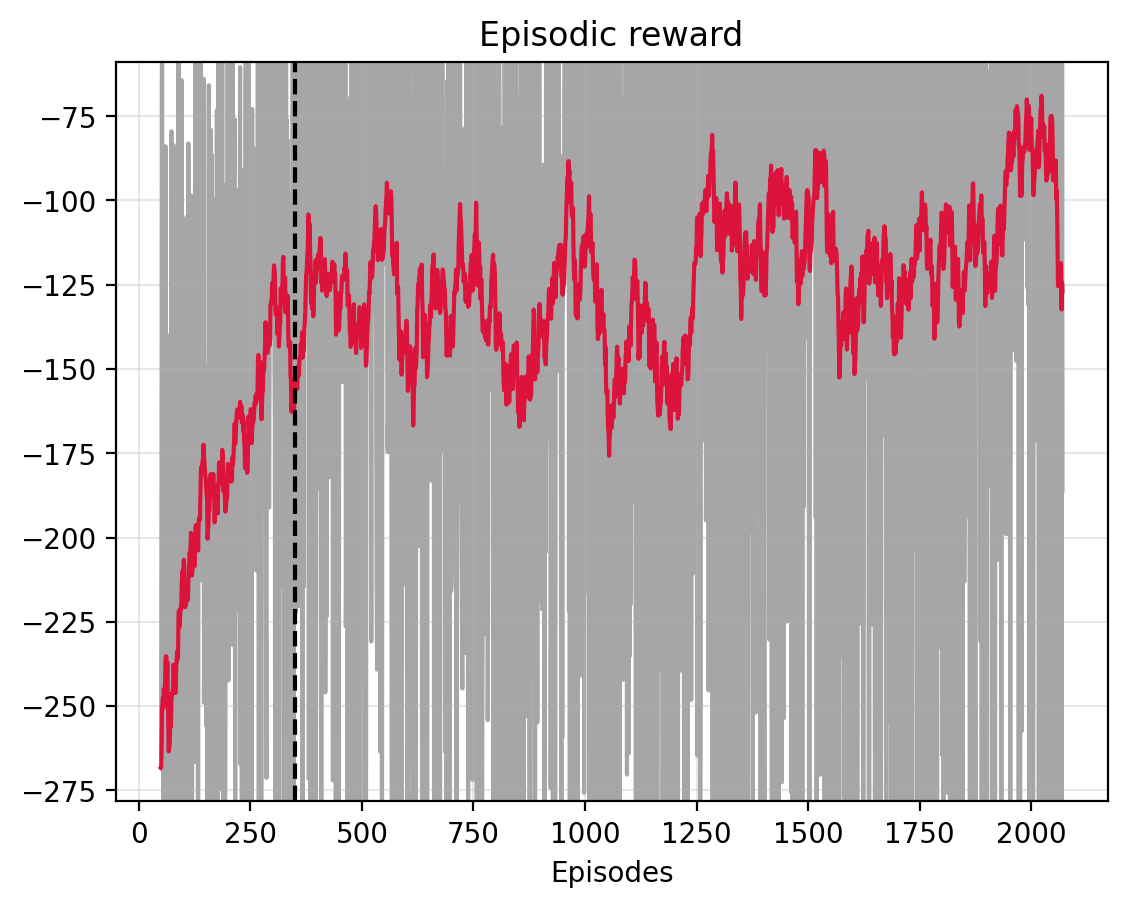

In [11]:
final_rewards.ewm(span=50, min_periods=50).mean().plot(c="crimson")
ymin, ymax = plt.ylim()
final_rewards.iloc[50:].plot(zorder=0, c="gray", alpha=0.7)
plt.ylim(ymin, ymax)
plt.axvline(x=350, c="black", linestyle="dashed")
plt.title("Episodic reward")
plt.xlabel("Episodes")
plt.grid(alpha=0.3)

## Oracle $Q_t$
Modififying the value of $Q_t$ by hand

In [12]:
n_steps = 200_000
eps = 5e-4
gamma = 0.9999
Rt = np.eye(1) * 1.0

all_rewards = np.zeros(n_steps)
env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=314)
final_rewards = []

checkpoint_episodes = [1, 250, 500, 750, 1000, 1250, 1500]
checkpoint_weights = []

dim_phi = len(phi(observation))
np.random.seed(314)
M = np.random.randn(n_actions, dim_phi)
M = M.astype("float32")
M = np.zeros((n_actions, dim_phi))
Sigma = np.einsum("a,ij->aij", np.ones(n_actions), np.eye(dim_phi)) * 10.0

n_episodes = 0
action = eps_greedy_choice(M, observation, eps)
episode_reward = 0.0

for t in (pbar := tqdm(range(n_steps))):
    observation_next, reward, terminated, truncated, info = env.step(action)
    
    action_next = eps_greedy_choice(M, observation_next, eps)

    reset = terminated or truncated
    gamma_step = 0.0 if reset else gamma

    qt = 1e-4 if n_episodes < 350 else 0.0
    
    M, Sigma = update_qweights_kf(
        M, Sigma, observation, action, reward, observation_next, action_next, gamma_step, Rt, qt
    )
    
    if reset:
        final_rewards.append(episode_reward)
        observation, info = env.reset()
        action = eps_greedy_choice(M, observation, eps)
        episode_reward = 0.0

        if n_episodes in checkpoint_episodes:
            checkpoint_weights.append(M)
        
        n_episodes += 1
    else:
        episode_reward += reward
        observation = observation_next
        action = action_next

    if t % 10_000 == 0:
        pbar.set_description(f"{reward:0.2f}")
    all_rewards[t] = reward

# attach last 
checkpoint_weights.append(M)
checkpoint_episodes.append(n_episodes)

checkpoint_weights = np.stack(checkpoint_weights)
final_rewards = pd.Series(final_rewards)
print(f"\n{all_rewards.sum()}")
env.close()

  0%|                                                                                                                                                         | 0/200000 [00:00<?, ?it/s]/Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
4.97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:46<00:00, 4303.37it/s]


-18995.602327685323


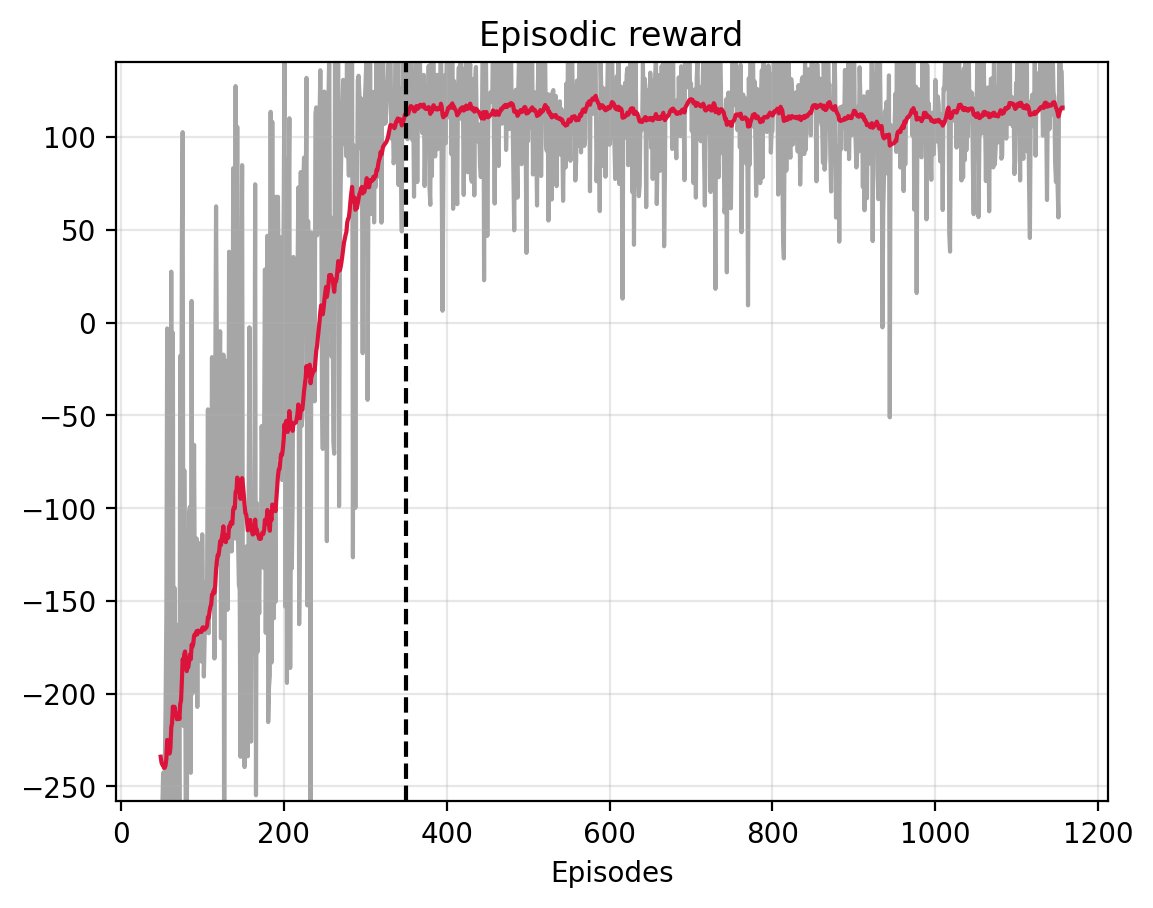

In [13]:
final_rewards.ewm(span=50, min_periods=50).mean().plot(c="crimson")
ymin, ymax = plt.ylim()
final_rewards.iloc[50:].plot(zorder=0, c="gray", alpha=0.7)
plt.ylim(ymin, ymax)
plt.axvline(x=350, c="black", linestyle="dashed")
plt.title("Episodic reward")
plt.xlabel("Episodes")
plt.grid(alpha=0.3)

## Testing policy

In [15]:
n_steps = 1000
eps = 5e-4

observation, info = env.reset(seed=3141)
action = eps_greedy_choice(M, observation, eps)

observations = []
rewards = []
actions_hist = []

episode_reward = 0.0
for t in range(n_steps):
    observation, reward, terminated, truncated, info = env.step(action)
    
    action = eps_greedy_choice(M, observation, eps)

    reset = terminated or truncated
    rewards.append(reward)
    actions_hist.append(action)
    observations.append(observation)
    
    if reset:
        observation, info = env.reset()
        # action = eps_greedy_choice(W, observation, eps)
        break

observations = np.array(observations)
rewards = np.array(rewards)
print(f"\n{rewards.sum()}")


8.756896409460985


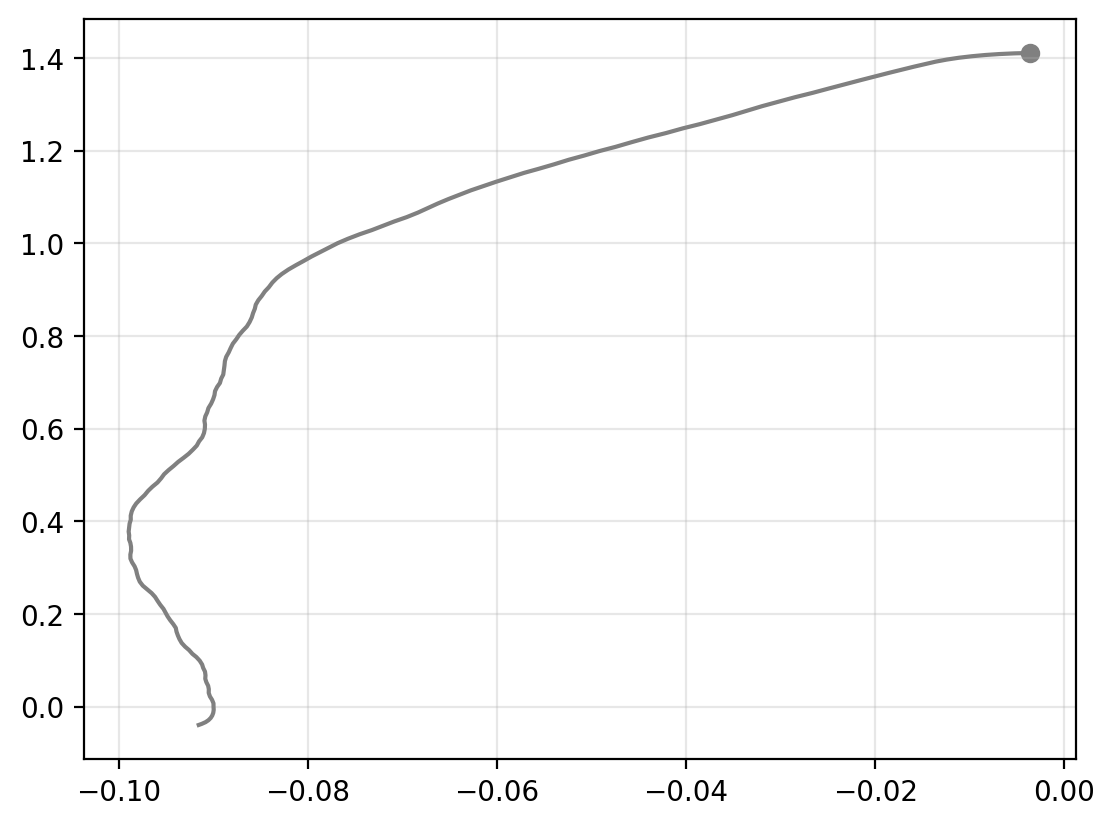

In [16]:
plt.plot(*observations[:, :2].T, c="gray")
plt.scatter(*observations[0, :2], c="gray")
plt.grid(alpha=0.3)

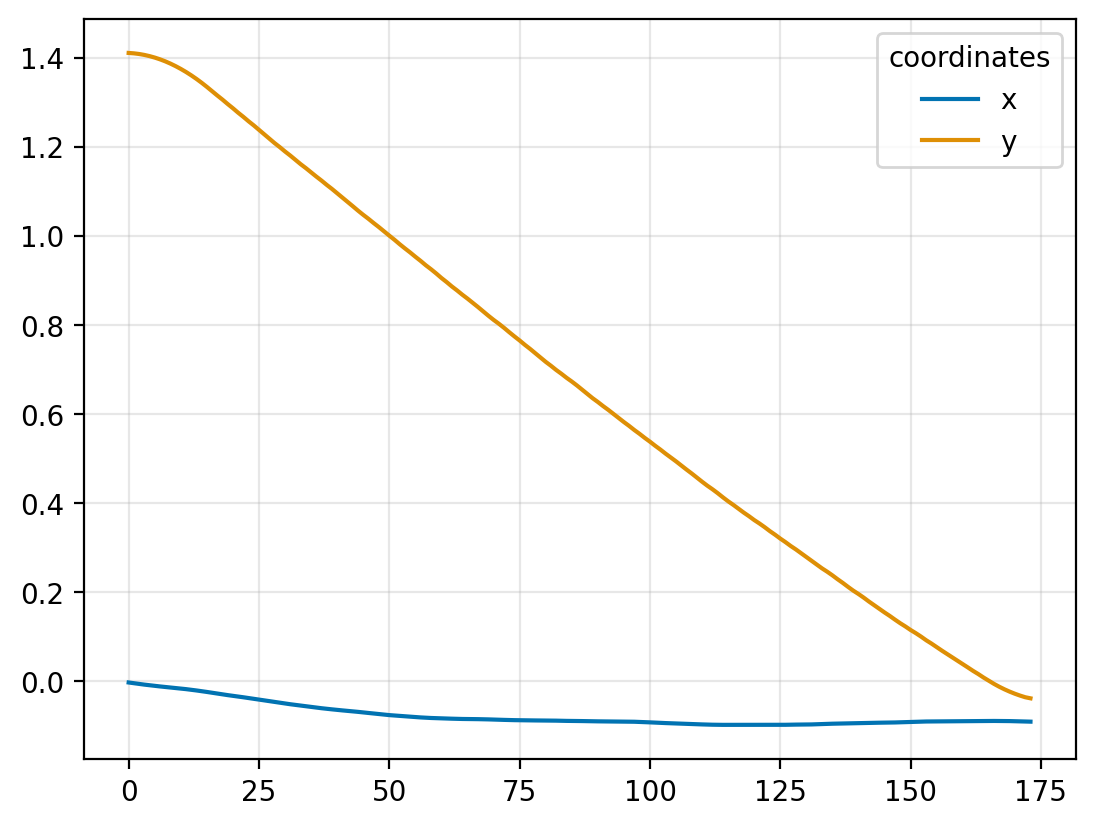

In [17]:
plt.plot(observations[:, :2], label=["x", "y"])
plt.legend(title="coordinates")
plt.grid(alpha=0.3)

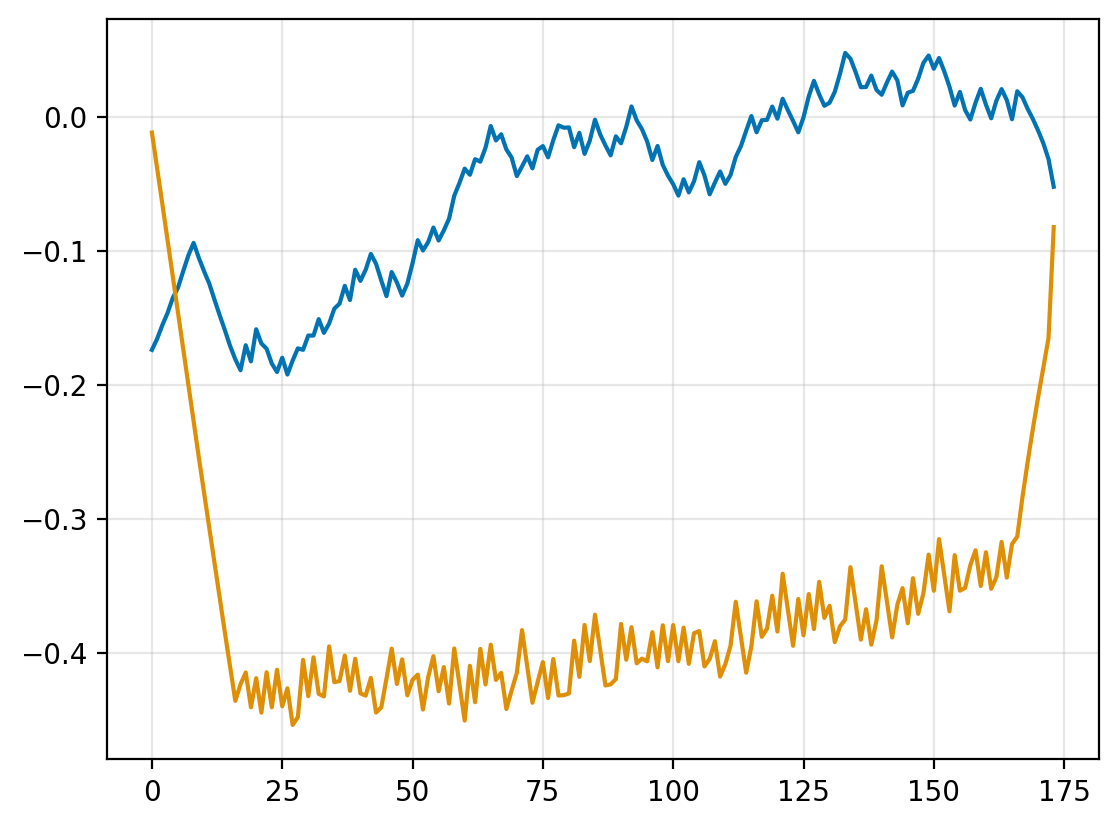

In [18]:
plt.plot(observations[:, 2:4])
plt.grid(alpha=0.3)

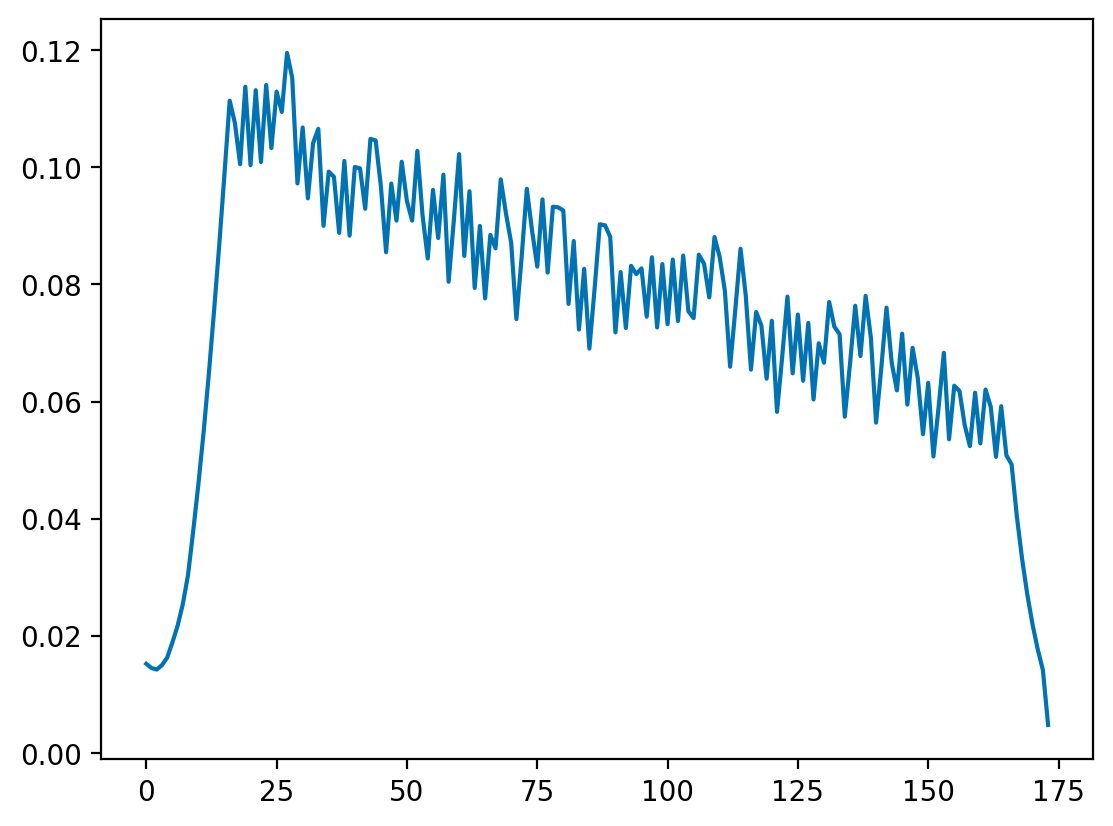

In [19]:
vel = np.power(observations[:, 2:4], 2).mean(axis=1)
plt.plot(vel)

In [20]:
observation, info = env.reset(seed=314)

In [21]:
xspace = np.linspace(-1, 1, 100)
yspace = np.linspace(0, 2, 100)
Ogrid = np.stack(np.meshgrid(xspace, yspace))
Ogrid = np.einsum("mij->ijm", Ogrid)
Fgrid = np.zeros((100, 100))

In [22]:
for i in range(100):
    for j in range(100):
        sub_pos = Ogrid[i,j]
        observation[:2] = sub_pos
        res = eval_action_value(M, observation, actions)
        Fgrid[i,j] = res.argmax()

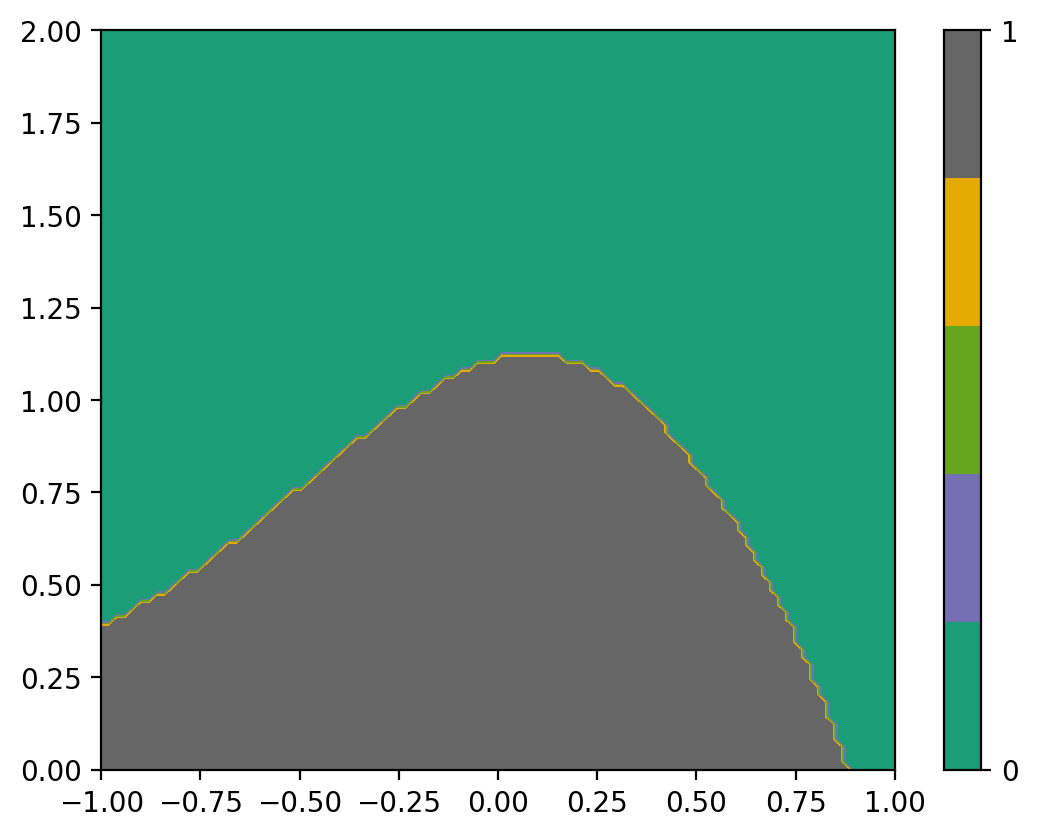

In [23]:
plt.contourf(xspace, yspace, Fgrid, cmap="Dark2", levels=4)
plt.colorbar(ticks=actions)

## Multiple runs

In [24]:
colors = np.linspace(0, 1, len(checkpoint_episodes))
colors = plt.cm.viridis(colors)

-366.6315692608989
-146.99012416927107
-29.297763716244177
-24.331991309257504
-25.661641401420226
-21.683557869508732


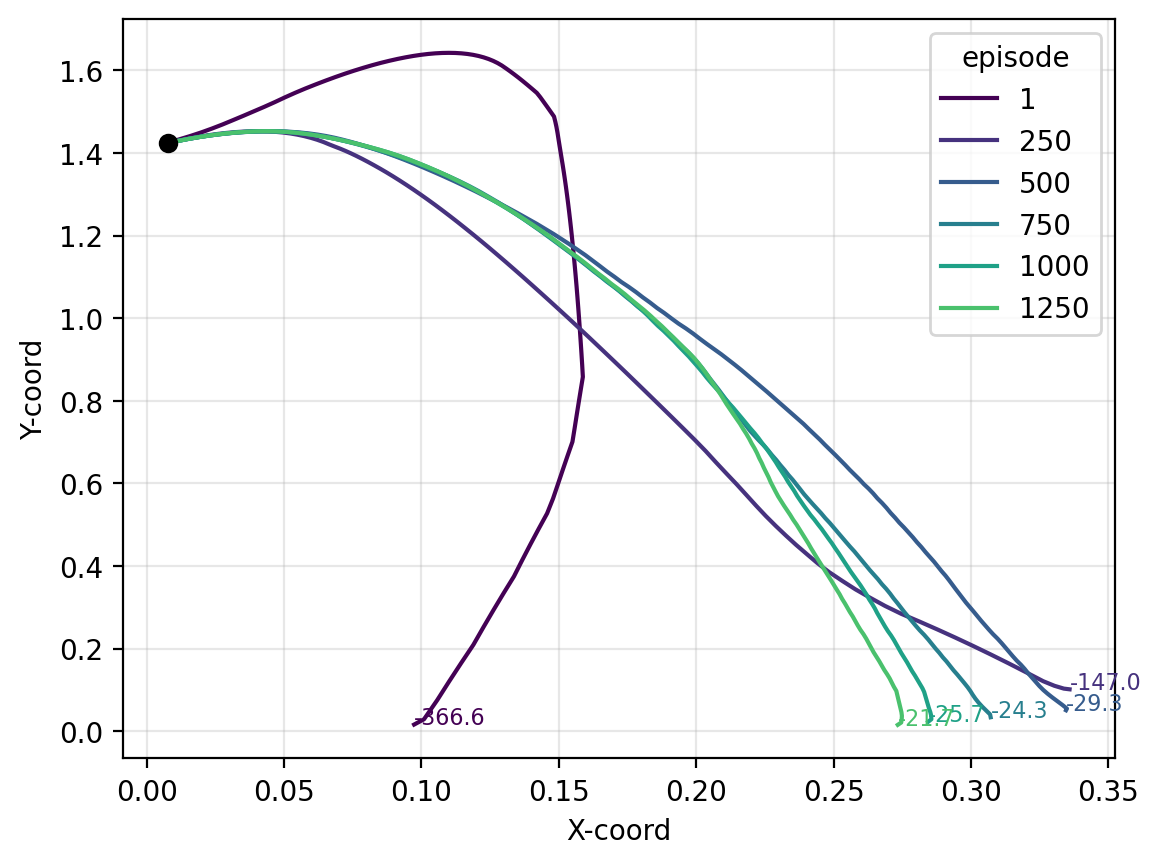

In [25]:
n_steps = 1000
eps = 5e-4

for W, episode, color in zip(checkpoint_weights, checkpoint_episodes, colors):
    observation, info = env.reset(seed=314)
    action = eps_greedy_choice(W, observation, eps)
    
    observations = []
    actions_hist = []
    
    episode_reward = 0.0
    for t in range(n_steps):
        observation, reward, terminated, truncated, info = env.step(action)
        
        action = eps_greedy_choice(W, observation, eps)
    
        reset = terminated or truncated
        actions_hist.append(action)
        observations.append(observation)
        
        episode_reward += reward
        if reset:
            observation, info = env.reset()
            # action = eps_greedy_choice(W, observation, eps)
            break
    
    observations = np.array(observations)

    plt.plot(*observations[:, :2].T, label=episode, c=color)
    
    last_x, last_y = observations[-1, :2]
    last_r = f"{episode_reward:0.1f}"
    plt.text(last_x, last_y, last_r, color=color, fontsize=8)
    print(episode_reward)

plt.scatter(*observations[0, :2], c="black", zorder=2)
plt.xlabel("X-coord")
plt.ylabel("Y-coord")
plt.legend(title="episode")
plt.grid(alpha=0.3)